In [263]:
import pandas as pd
import csv
import os
import time
from collections import defaultdict
import numpy as np
import itertools
import db_structure
import networkx as nx
from imp import reload
import matplotlib.pyplot as plt
import utilities as u
from flask import jsonify
import logging
import exceptions
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

logging.basicConfig(format=' %(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
%load_ext autoreload
%aimport -web
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [316]:
db = db_structure.DB(os.path.join('datasets', 'TOPICC'))
dm = db_structure.DataManager(db)

 2019-08-18 12:17:12,617 - INFO - Loading datasets/TOPICC
 2019-08-18 12:17:12,618 - INFO - Loading arch file: datasets/TOPICC/TOPICC.arch


In [543]:
chosen_ind_idxs = ['322', '5']  # Sex, lowpH
chosen_outcome_idx = '27'  # low CO2

if chosen_outcome_idx is None:
    all_chosen_idxs = chosen_ind_idxs
else:
    all_chosen_idxs = [chosen_outcome_idx] + chosen_ind_idxs

paths = db.find_paths_multi_columns(all_chosen_idxs)
df = dm.get_biggest_joined_df_option_from_paths(paths, filter_col_idxs=all_chosen_idxs)
groupby_col_headers = ['Sex_[HOSPITALADMIT]', 'LowpH_[PHYSIOSTATUS]']
outcome_col_header = 'LowCO2_[PHYSIOSTATUS]'

filters = {'5': {'type': 'range', 'filter': {'min': 3.31, 'max': 7.74, 'bins': '3'}}, '322': None, '27': None}
df = dm.filter_df(df, filters)

/home/sareen/.local/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/sareen/.local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [532]:
df.head()

,LowCO2_[PHYSIOSTATUS],Sex_[HOSPITALADMIT],LowpH_[PHYSIOSTATUS]
1,7.0,Female,"(6.263, 7.74]"
3,21.0,Male,"(6.263, 7.74]"
4,NaN,Female,"(6.263, 7.74]"
5,NaN,Female,"(6.263, 7.74]"
6,22.0,Male,"(6.263, 7.74]"


In [567]:
df_t = (df.groupby(groupby_col_headers).mean())#.round(2).reset_index()
#df_t['LowCO2_[PHYSIOSTATUS]'] = df_t['LowCO2_[PHYSIOSTATUS]'].fillna(0)
df_t

LowCO2_[PHYSIOSTATUS]
Sex_[HOSPITALADMIT] LowpH_[PHYSIOSTATUS]                       
Female              (3.306, 4.787]                          NaN
                    (4.787, 6.263]                          NaN
                    (6.263, 7.74]                     20.887507
Male                (3.306, 4.787]                    22.000000
                    (4.787, 6.263]                          NaN
                    (6.263, 7.74]                     21.535336

In [566]:
type(df[outcome_col_header])#.mean())

pandas.core.series.Series

In [544]:
dm.aggregate_df(df, groupby_col_idxs=chosen_ind_idxs, aggregate_col_idx=chosen_outcome_idx, aggregate_fxn='Count')

 2019-08-18 22:27:17,453 - DEBUG - ['Sex_[HOSPITALADMIT]', 'LowpH_[PHYSIOSTATUS]']
 2019-08-18 22:27:17,455 - DEBUG - ['LowCO2_[PHYSIOSTATUS]']


AttributeError: 'DataFrameGroupBy' object has no attribute 'value_counts'

In [547]:
g = df.groupby(groupby_col_headers)#[outcome_col_header]
g[outcome_col_header].value_counts()
g.

'LowCO2_[PHYSIOSTATUS]'

In [505]:
df_t

,Sex_[HOSPITALADMIT],LowpH_[PHYSIOSTATUS],LowCO2_[PHYSIOSTATUS]
0,Female,"(3.306, 4.787]",NaN
1,Female,"(4.787, 6.263]",NaN
2,Female,"(6.263, 7.74]",20.89
3,Male,"(3.306, 4.787]",22.00
4,Male,"(4.787, 6.263]",NaN
5,Male,"(6.263, 7.74]",21.54


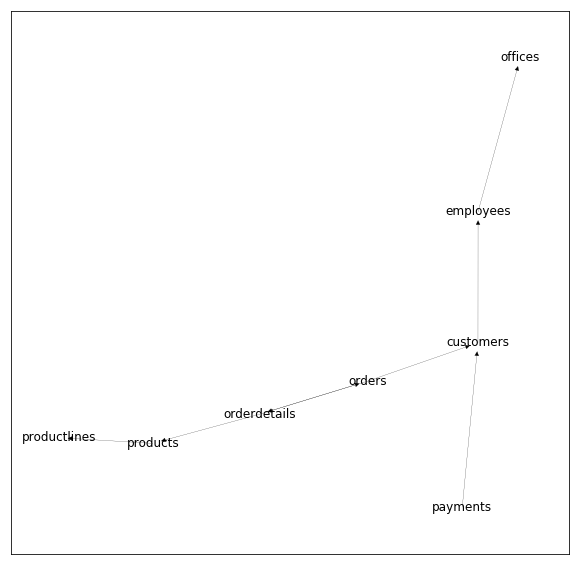

In [72]:
draw_db = db

G = nx.DiGraph()
G.add_nodes_from(draw_db.table_names)
for table_name in draw_db.table_names:
    for sibling in draw_db.find_table_siblings(table_name):
        G.add_edge(table_name, sibling)
        G.add_edge(sibling, table_name)
    for child in draw_db.find_table_children(table_name):
        G.add_edge(table_name, child)
plt.figure(figsize=(10,10))

#draw with networkx built-ins
nx.draw_networkx(G, node_shape="None", width=0.2)

#OR

#draw using pygraphviz
#A = nx.nx_agraph.to_agraph(G)
#H = nx.nx_agraph.from_agraph(A)
#nx.draw_spring(H, node_shape="None", with_labels=True, width=0.2)

In [134]:
np.int64

numpy.int64